#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션①
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.


### (2) 미션②  
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* 1) Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.
* 2) Target을 **개별 행동 여부**로 구분
    * 6가지의 행동을 분류하는 분석도 중요하지만, 개별 행동에만 특별히 영향을 받는 feature들도 있습니다.
    * 예를 들어, 계단을 오르는 행동(Walking_upstairs)과 관련이 큰 feature가 있을 것입니다. [계단을 오르는 행동]인지 아닌지로 구분하는 targe을 추가하여 EDA를 수행해 봅시다.


## 1.환경설정

### (1) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 필요하다고 판단되는 라이브러리를 추가하세요.




* 변수 중요도 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [37]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,100))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용 데이터셋
    * feature.csv : feature 이름을 계층구조로 정리한 데이터  
 <br/>
    

* 세부 요구사항
    - 전체 데이터 'data01_train.csv' 를 불러와 'data' 변수에 저장합니다.
    - 센서 그룹 데이터 'feature.csv' 를 불러와 'features' 변수에 저장합니다.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv('/content/drive/MyDrive/에이블스쿨_미니프로젝트/Mini_Project5_2/data01_train.csv')
feature=pd.read_csv('/content/drive/MyDrive/에이블스쿨_미니프로젝트/Mini_Project5_2/features.csv')

## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 25.3+ MB


In [6]:
data.shape

(5881, 563)

In [7]:
data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594,17.381568
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479,8.938316
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143,1.000000
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555,8.000000
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951,19.000000
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932,26.000000
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000,30.000000


In [8]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sensor        561 non-null    object
 1   agg           561 non-null    object
 2   axis          436 non-null    object
 3   feature_name  561 non-null    object
dtypes: object(4)
memory usage: 17.7+ KB


In [12]:
feature.head()

,sensor,agg,axis,feature_name
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z
3,tBodyAcc,std(),X,tBodyAcc-std()-X
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y


### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [10]:
data['Activity'].unique()

array(['STANDING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS', 'SITTING'], dtype=object)

In [9]:
data['Activity'].value_counts()

LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: Activity, dtype: int64

In [11]:
data['Activity'].value_counts(normalize=True)

LAYING                0.189594
STANDING              0.184833
SITTING               0.175480
WALKING               0.169699
WALKING_UPSTAIRS      0.145894
WALKING_DOWNSTAIRS    0.134501
Name: Activity, dtype: float64

### (3) 센서 그룹 데이터: features

* **세부 요구사항**
    - feature 이름에 대한 계층 구조별로 변수의 수를 카운트 해 봅시다.
        - sensor 별 변수의 개수
        - agg(regation) 별 변수의 개수
        - axis 별 변수의 개수

In [78]:
feature.shape

(561, 4)

In [79]:
feature.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=True)
feature.shape

(533, 4)

In [80]:
feature.groupby('sensor', as_index=False)['feature_name'].nunique().sort_values('feature_name', ascending=False)

,sensor,feature_name
2,fBodyAccJerk,79
1,fBodyAcc,79
7,fBodyGyro,51
9,tBodyAccJerk,40
16,tGravityAcc,40
13,tBodyGyroJerk,40
8,tBodyAcc,40
12,tBodyGyro,40
11,tBodyAccMag,13
15,tBodyGyroMag,13


In [29]:
feature.groupby('agg', as_index=False)['feature_name'].nunique()

,agg,feature_name
0,X,1
1,Y,1
2,Z,1
3,arCoeff(),60
4,arCoeff()1,5
5,arCoeff()2,5
6,arCoeff()3,5
7,arCoeff()4,5
8,bandsEnergy(),98
9,correlation(),15


In [30]:
feature.groupby('axis', as_index=False)['feature_name'].nunique()

,axis,feature_name
0,"1,16",3
1,"1,16.1",2
2,"1,16.2",2
3,"1,24",3
4,"1,24.1",2
...,...,...
57,"Z,2",5
58,"Z,3",5
59,"Z,4",5
60,gravity,1


## 3.데이터 분석 : 미션1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다.
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

In [18]:
target='Activity'
X=data.drop(target,axis=1)
y=data[target]
x_train, x_val, y_train, y_val = train_test_split(X,y,test_size=0.2,)

In [31]:
model = RandomForestClassifier()
model.fit(x_train, y_train)

RandomForestClassifier()

In [40]:
y_pred=model.predict(x_val)
print(classification_report(y_val, y_pred))

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       207
           SITTING       0.94      0.93      0.94       216
          STANDING       0.94      0.95      0.94       228
           WALKING       0.99      0.98      0.99       186
WALKING_DOWNSTAIRS       0.97      0.99      0.98       156
  WALKING_UPSTAIRS       0.98      0.98      0.98       184

          accuracy                           0.97      1177
         macro avg       0.97      0.97      0.97      1177
      weighted avg       0.97      0.97      0.97      1177



In [46]:
fi_df = plot_feature_importance(model.feature_importances_, list(x_train), result_only = False, topn = 'all')

Output hidden; open in https://colab.research.google.com to view.

### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

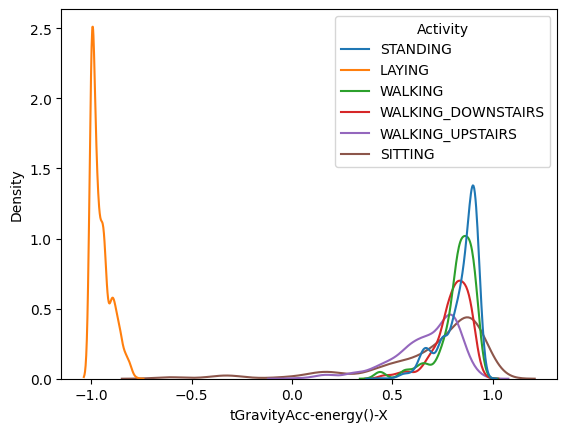

In [57]:
#상위
sns.kdeplot(x=list(fi_df['feature_name'])[0], data=data, hue=target)
plt.show()

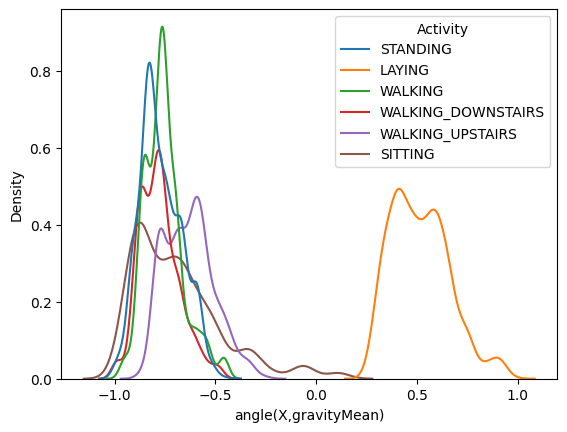

In [62]:
sns.kdeplot(x=list(fi_df['feature_name'])[1], data=data, hue=target)
plt.show()

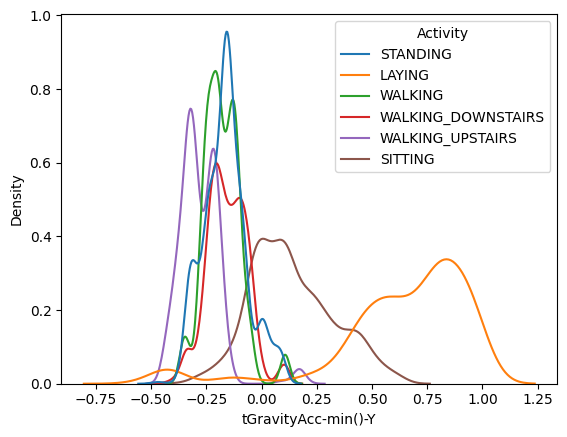

In [63]:
sns.kdeplot(x=list(fi_df['feature_name'])[2], data=data, hue=target)
plt.show()

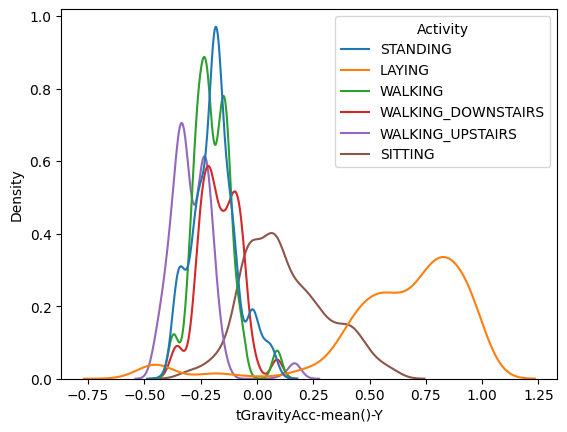

In [64]:
sns.kdeplot(x=list(fi_df['feature_name'])[3], data=data, hue=target)
plt.show()

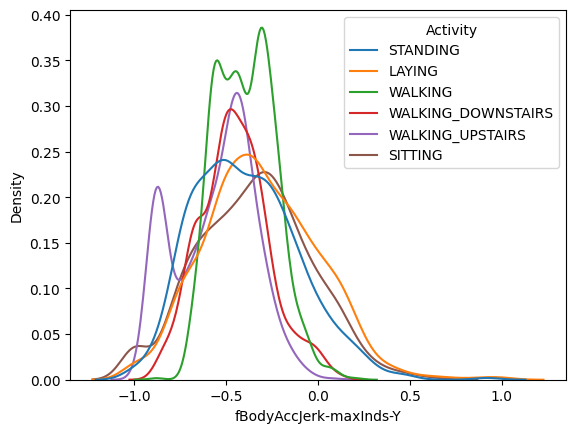

In [65]:
#하위
sns.kdeplot(x=list(fi_df['feature_name'])[-1], data=data, hue=target)
plt.show()

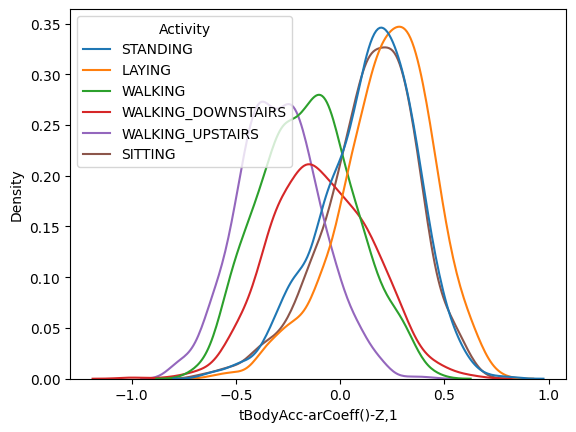

In [69]:
sns.kdeplot(x=list(fi_df['feature_name'])[-2], data=data, hue=target)
plt.show()

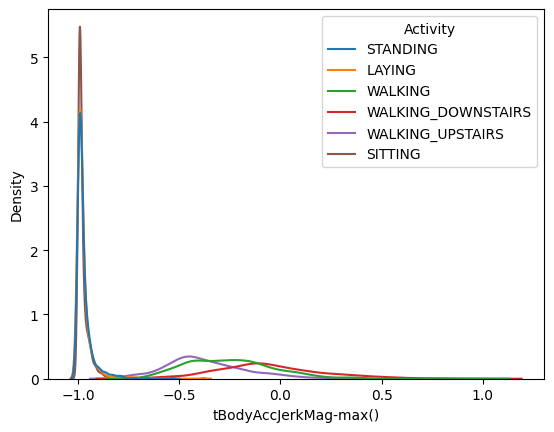

In [70]:
sns.kdeplot(x=list(fi_df['feature_name'])[-3], data=data, hue=target)
plt.show()

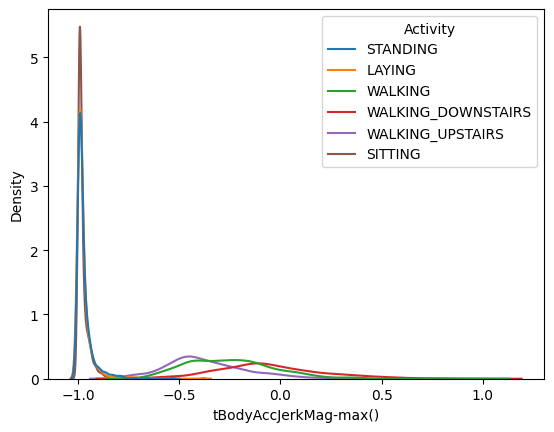

In [71]:
sns.kdeplot(x=list(fi_df['feature_name'])[-3], data=data, hue=target)
plt.show()

### (3) feature 그룹별 분석

* **세부 요구사항**
    - 제공된 features.csv 에는 feature에 대한 계층구조를 정리해 놓았습니다.
    - features와 변수중요도 결과를 merge 하시오.
    - sensor 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석을 수행 하시오.
    - sensor + agg 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석을 수행 하시오.


In [88]:
feature.shape, fi_df.shape

((533, 4), (562, 2))

In [90]:
len(set(fi_df['feature_name']))

562

In [81]:
merge_df = pd.merge(feature, fi_df)

In [83]:
merge_df.groupby('sensor', as_index=False)['feature_importance'].sum().sort_values('feature_importance', ascending=False)

,sensor,feature_importance
16,tGravityAcc,0.336063
2,fBodyAccJerk,0.109683
1,fBodyAcc,0.078183
0,angle,0.067301
9,tBodyAccJerk,0.064831
7,fBodyGyro,0.054762
8,tBodyAcc,0.048767
3,fBodyAccMag,0.045379
17,tGravityAccMag,0.036312
13,tBodyGyroJerk,0.035603


In [86]:
merge_df.groupby(['sensor', 'agg'], as_index=False)['feature_importance'].sum().sort_values('feature_importance', ascending=False).head(10)

,sensor,agg,feature_importance
197,tGravityAcc,arCoeff(),0.075865
204,tGravityAcc,mean(),0.061974
205,tGravityAcc,min(),0.059473
199,tGravityAcc,energy(),0.058909
21,fBodyAccJerk,bandsEnergy(),0.057031
203,tGravityAcc,max(),0.056099
0,angle,X,0.032258
7,fBodyAcc,bandsEnergy(),0.028211
1,angle,Y,0.021954
117,tBodyAccJerk,mad(),0.015843


## 4.데이터 분석 : 미션2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* 1) Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.
* 2) Target을 **개별 행동 여부**로 구분
    * 6가지의 행동을 분류하는 분석도 중요하지만, 개별 행동에만 특별히 영향을 받는 feature들도 있습니다.
    * 예를 들어, 계단을 오르는 행동(Walking_upstairs)과 관련이 큰 feature가 있을 것입니다. [계단을 오르는 행동]인지 아닌지로 구분하는 targe을 추가하여 EDA를 수행해 봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_dynamic 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_dynamic 추가

In [91]:
data['is_dynamic'] = data[target].apply(lambda x:0 if x in ['STANDING', 'SITTING', 'LAYING'] else 1)

In [92]:
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,STANDING,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,WALKING,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,WALKING_DOWNSTAIRS,1


In [96]:
data.iloc[:,:-2]

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,-0.305772,-0.690363,-0.034888,-0.261437,-0.391477,-0.877612,-0.912365,0.114009,0.080146,21
5877,0.191568,0.013328,-0.105174,-0.126969,-0.121729,-0.327480,-0.192523,-0.109923,-0.295286,0.078644,...,-0.622617,-0.879215,0.721718,0.623151,0.866858,-0.445660,-0.690278,0.303194,-0.044188,15
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,-0.597610,-0.886851,0.060173,0.228739,0.684400,-0.216665,0.620363,-0.437247,-0.571840,19
5879,0.212787,-0.048130,-0.121001,-0.041373,0.052449,-0.585361,-0.100714,0.023353,-0.554707,0.219814,...,0.196921,-0.053556,0.260880,0.551742,-0.943773,-0.862899,-0.718009,0.292856,0.024920,6


#### 2) 기본모델 생성

In [97]:
target = 'is_dynamic'
X=data.iloc[:,:-2]
y=data[target]
x_train, x_val, y_train, y_val = train_test_split(X,y,test_size=0.2)

In [98]:
model = RandomForestClassifier()
model.fit(x_train, y_train)

RandomForestClassifier()

In [99]:
y_pred = model.predict(x_val)
print(classification_report(y_val, y_pred))
fi_df = plot_feature_importance(model.feature_importances_, list(x_train), result_only = False, topn = 'all')

Output hidden; open in https://colab.research.google.com to view.

#### 3) 변수중요도 상위 5개 분석

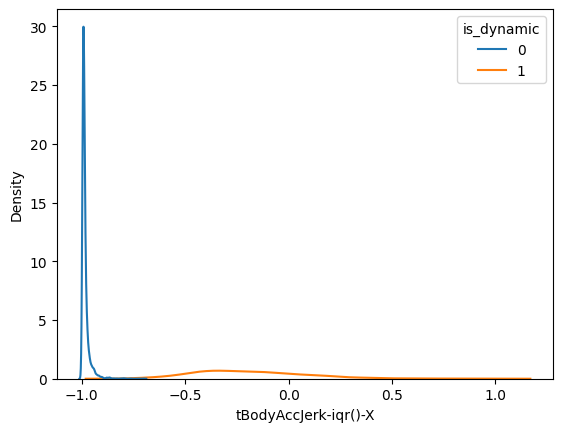

In [100]:
sns.kdeplot(x=list(fi_df['feature_name'])[0], data=data, hue=target)
plt.show()

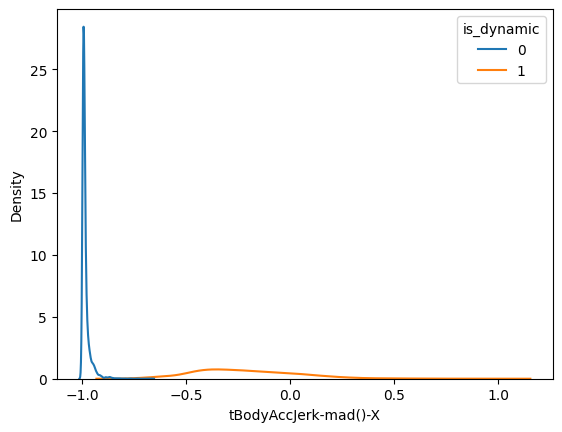

In [101]:
sns.kdeplot(x=list(fi_df['feature_name'])[1], data=data, hue=target)
plt.show()

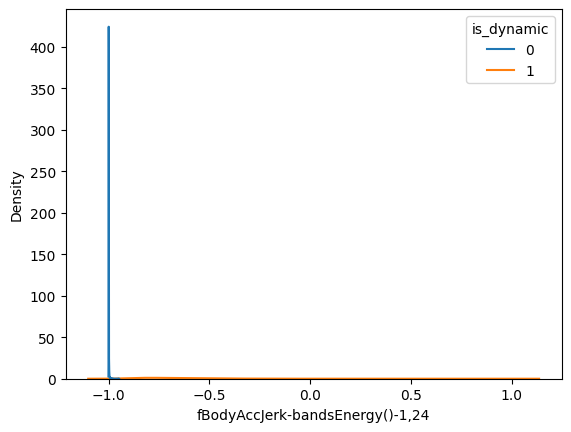

In [102]:
sns.kdeplot(x=list(fi_df['feature_name'])[2], data=data, hue=target)
plt.show()

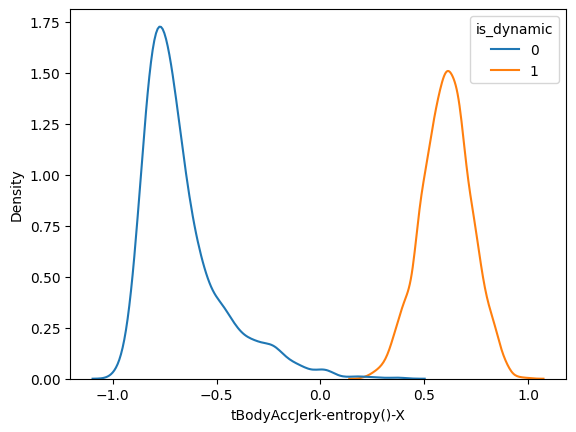

In [104]:
sns.kdeplot(x=list(fi_df['feature_name'])[3], data=data, hue=target)
plt.show()

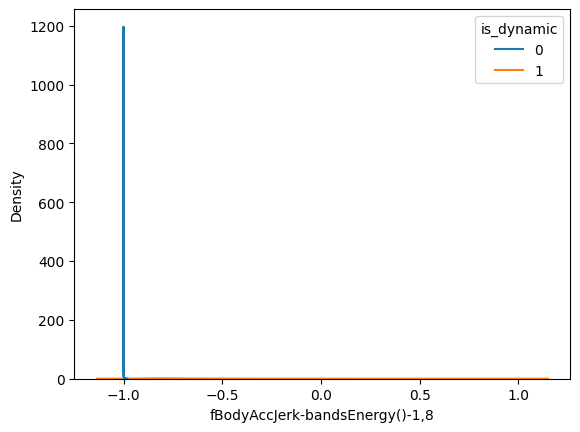

In [103]:
sns.kdeplot(x=list(fi_df['feature_name'])[4], data=data, hue=target)
plt.show()

#### 4) feature 그룹별 분석

In [105]:
merge_df = pd.merge(feature, fi_df)

In [106]:
merge_df.groupby('sensor', as_index=False)['feature_importance'].sum().sort_values('feature_importance', ascending=False)

,sensor,feature_importance
2,fBodyAccJerk,0.359658
9,tBodyAccJerk,0.339426
13,tBodyGyroJerk,0.089677
10,tBodyAccJerkMag,0.079673
8,tBodyAcc,0.039960
7,fBodyGyro,0.039725
1,fBodyAcc,0.030123
12,tBodyGyro,0.010039
4,fBodyBodyAccJerkMag,0.009998
16,tGravityAcc,0.001206


In [107]:
merge_df.groupby(['sensor', 'agg'], as_index=False)['feature_importance'].sum().sort_values('feature_importance', ascending=False).head(10)

,sensor,agg,feature_importance
21,fBodyAccJerk,bandsEnergy(),0.160045
116,tBodyAccJerk,iqr(),0.109773
117,tBodyAccJerk,mad(),0.069846
27,fBodyAccJerk,max(),0.049927
115,tBodyAccJerk,entropy(),0.049881
122,tBodyAccJerk,std(),0.040026
114,tBodyAccJerk,energy(),0.039975
164,tBodyGyroJerk,iqr(),0.029992
34,fBodyAccJerk,std(),0.029970
26,fBodyAccJerk,mad(),0.029948


### (2) 개별 동작 분석 : is_standing


* **세부 요구사항**
    - Target인 Activity를 is_standing 변수로 변경하시오.
        * 값 1 : STANDING
        * 값 0 : 나머지
    - is_standing 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_standing 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_standing 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_standing 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [119]:
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,is_dynamic,is_standing
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING,0,1
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING,0,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,STANDING,0,1
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,WALKING,1,0
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,WALKING_DOWNSTAIRS,1,0


In [116]:
data['is_standing']=0
data.loc[data['Activity']=='STANDING','is_standing']=1

In [121]:
target = 'is_standing'
X=data.iloc[:,:-3]
y=data[target]
x_train, x_val, y_train, y_val = train_test_split(X,y,test_size=0.2)
model = RandomForestClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_val)
print(classification_report(y_val, y_pred))
fi_df = plot_feature_importance(model.feature_importances_, list(x_train), result_only = False, topn = 'all')

Output hidden; open in https://colab.research.google.com to view.

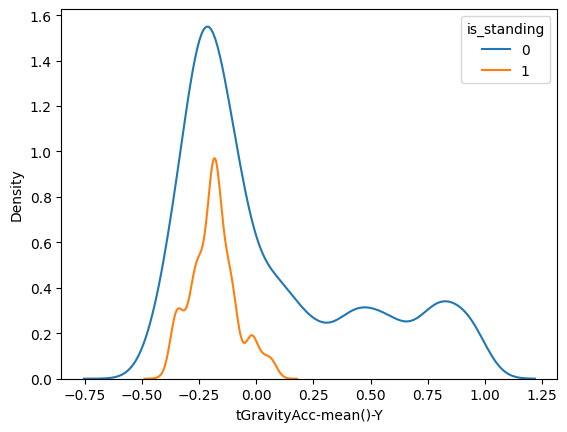

In [122]:
sns.kdeplot(x=list(fi_df['feature_name'])[0], data=data, hue=target)
plt.show()

In [123]:
merge_df = pd.merge(feature, fi_df)
display(merge_df.groupby('sensor', as_index=False)['feature_importance'].sum().sort_values('feature_importance', ascending=False))
display(merge_df.groupby(['sensor', 'agg'], as_index=False)['feature_importance'].sum().sort_values('feature_importance', ascending=False).head(10))

,sensor,feature_importance
16,tGravityAcc,0.377743
1,fBodyAcc,0.124565
0,angle,0.101948
7,fBodyGyro,0.071689
12,tBodyGyro,0.065358
8,tBodyAcc,0.058809
13,tBodyGyroJerk,0.039178
2,fBodyAccJerk,0.028240
17,tGravityAccMag,0.022924
11,tBodyAccMag,0.022622


,sensor,agg,feature_importance
203,tGravityAcc,max(),0.100515
204,tGravityAcc,mean(),0.094257
205,tGravityAcc,min(),0.086713
7,fBodyAcc,bandsEnergy(),0.049531
199,tGravityAcc,energy(),0.047279
1,angle,Y,0.036043
2,angle,Z,0.031474
0,angle,X,0.031058
87,fBodyGyro,bandsEnergy(),0.022341
200,tGravityAcc,entropy(),0.018263


### (3) 개별 동작 분석 : is_sitting


* **세부 요구사항**
    - Target인 Activity를 is_sitting 변수로 변경하시오.
        * 값 1 : SITTING
        * 값 0 : 나머지
    - is_sitting 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_sitting 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_sitting 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_sitting 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


### (4) 개별 동작 분석 : is_laying


* **세부 요구사항**
    - Target인 Activity를 is_laying 변수로 변경하시오.
        * 값 1 : LAYING
        * 값 0 : 나머지
    - is_laying 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_laying 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_laying 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_laying 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


### (5) 개별 동작 분석 : is_walking


* **세부 요구사항**
    - Target인 Activity를 is_walking 변수로 변경하시오.
        * 값 1 : WALKING
        * 값 0 : 나머지
    - is_walking 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [125]:
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,is_dynamic,is_standing,is_walking
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING,0,1,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING,0,0,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,STANDING,0,1,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,WALKING,1,0,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,WALKING_DOWNSTAIRS,1,0,0


In [124]:
data['is_walking']=0
data.loc[data['Activity']=='WALKING','is_walking']=1

In [126]:
target = 'is_walking'
X=data.iloc[:,:-4]
y=data[target]
x_train, x_val, y_train, y_val = train_test_split(X,y,test_size=0.2)
model = RandomForestClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_val)
print(classification_report(y_val, y_pred))
fi_df = plot_feature_importance(model.feature_importances_, list(x_train), result_only = False, topn = 'all')

Output hidden; open in https://colab.research.google.com to view.

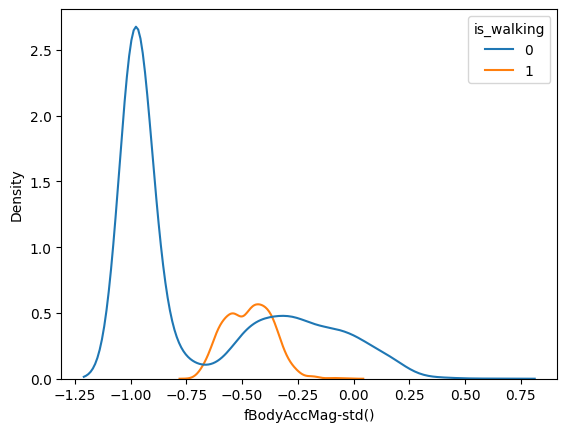

In [127]:
sns.kdeplot(x=list(fi_df['feature_name'])[0], data=data, hue=target)
plt.show()

In [128]:
merge_df = pd.merge(feature, fi_df)
display(merge_df.groupby('sensor', as_index=False)['feature_importance'].sum().sort_values('feature_importance', ascending=False))
display(merge_df.groupby(['sensor', 'agg'], as_index=False)['feature_importance'].sum().sort_values('feature_importance', ascending=False).head(10))

,sensor,feature_importance
16,tGravityAcc,0.185414
2,fBodyAccJerk,0.134299
1,fBodyAcc,0.127243
13,tBodyGyroJerk,0.089653
3,fBodyAccMag,0.079740
17,tGravityAccMag,0.065348
9,tBodyAccJerk,0.064219
8,tBodyAcc,0.055933
11,tBodyAccMag,0.055201
7,fBodyGyro,0.032724


,sensor,agg,feature_importance
197,tGravityAcc,arCoeff(),0.125764
21,fBodyAccJerk,bandsEnergy(),0.069423
7,fBodyAcc,bandsEnergy(),0.062725
47,fBodyAccMag,std(),0.033933
170,tBodyGyroJerk,std(),0.028665
165,tBodyGyroJerk,mad(),0.026453
27,fBodyAccJerk,max(),0.019901
13,fBodyAcc,max(),0.018526
208,tGravityAccMag,arCoeff()1,0.016036
34,fBodyAccJerk,std(),0.014839


### (6) 개별 동작 분석 : is_walking_up


* **세부 요구사항**
    - Target인 Activity를 is_walking_up 변수로 변경하시오.
        * 값 1 : WALKING_UPSTAIRS
        * 값 0 : 나머지
    - is_walking_up 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking_up 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking_up 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking_up 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


### (7) 개별 동작 분석 : is_walking_down


* **세부 요구사항**
    - Target인 Activity를 is_walking_down 변수로 변경하시오.
        * 값 1 : WALKING_DOWNSTAIRS
        * 값 0 : 나머지
    - is_walking_down 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking_down 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking_down 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking_down 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


## 5.특성 중요도 저장하기

* **세부 요구사항**
    - 지금까지 변수 중요도를 다양한 관점에서 뽑고 분석을 해 보았습니다.
        - 관점1 : 6개 행동 구분
        - 관점2 : 동적, 정적 행동 구분
        - 관점3 : Standing 여부 구분
        - 관점4 : Sitting 여부 구분
        - 관점5 : Laying 여부 구분
        - 관점6 : Walking 여부 구분
        - 관점7 : Walking_upstairs 여부 구분
        - 관점8 : Walking_downstairs 여부 구분
    - 모든 관점의 변수 중요도를 하나로 합친 후 저장
        - merge를 이용하여 features와 합칩니다.
        - joblib 패키지의 dump를 이용하여 결과를 저장합니다.

### (1) 하나로 합치기
* 합치기 위해서는 중요도 결과에서 feature_importance 칼럼 이름을 수정해야 합니다.
* pd.merge를 이용해서 하나씩 합치는 작업을 반복 합니다.

### (2) 저장하기
* joblib.dump를 이용하시오.
* 저장할 파일의 확장자는 보통 .pkl 입니다.